In [433]:
# load necessary libraries. install what you don't have
import numpy as np
import pandas as pd
import requests
import requests
import urllib
import os
import pprint
import json
import matplotlib.pyplot as plt
import seaborn as sns
import nltk 
import sklearn 

In [434]:
df = pd.read_excel("../DATA/original_data.xls", sheet_name="Data")

In [435]:
#Columns from original dataset we want to keep
columns_to_keep = ["Date", "S&P Comp. P", "Earnings", "Real Total Return Price" ]
df = df[columns_to_keep]

#Date format is inconsistent so lets make the formatting better and recognized as a date data type
df["Date"] = pd.to_datetime(df["Date"].astype(str), format="%Y-%m-%d")

#Filter out all dates before 1965, reconsider if this is a good selection later
df = df[df["Date"] >= "1965-01-01"]

#Added PE ratio column
df["PE Ratio"] = df["S&P Comp. P"] / df["Earnings"]

#Drop price and earnings columns because that data is now stored in the PE column
df = df.drop(columns=["S&P Comp. P", "Earnings"])

#df.rename(columns={"10 Year Annualized Stock Real Return": "10 Year Return"}, inplace=True)


print(df.head())

           Date  Real Total Return Price   PE Ratio
1128 1965-01-01            109618.976259  18.748925
1129 1965-02-01            110689.595261  18.709548
1130 1965-03-01            110707.980510  18.553419
1131 1965-04-01            112076.467028  18.585224
1132 1965-05-01            114020.425301  18.651798


In [436]:
# General function to calculate N-year returns
#Takes in 3 paramaters, a date, the dataframe, and then how many years out you want to calculate annual returns for
def get_n_year_return(date, df, years):
    #Calculates a target date by adding desired amount of years to current date to get futrue date (defaults to 10)
    target_date = date + pd.DateOffset(years=years)
    #Filters dataframe to only include dates that occur after the date provided to make searching quicker, then looks for the target date n years out
    
    # Filter the DataFrame to only include dates on or after the target date
    future_rows = df[df["Date"] >= target_date]

    # Check if there are any rows left after filtering
    if not future_rows.empty:
        # Select the first row (earliest available future date)
        future_row = future_rows.iloc[0]
    else:
        # If no future row is found, return None
        future_row = None


    if future_row is not None:
        #If some observation n years out exists, then using the compound annual growth formula given by original dataset calcualte the CAGR annual return 
        return (future_row["Real Total Return Price"] / df[df["Date"] == date]["Real Total Return Price"].values[0]) ** (1/years) - 1
    return None  # Return None if no valid future date is found

# Create an empty list to store results
five_year_returns = []
three_year_returns = []

# Iterate through each row in the DataFrame
for index, row in df.iterrows():
    five_year_returns.append(get_n_year_return(row["Date"], df, 5))
    three_year_returns.append(get_n_year_return(row["Date"], df, 3))

# Assign results to new columns
df["5 Year Annual Return"] = five_year_returns
df["3 Year Annual Return"] = three_year_returns

# Display the first few rows
print(df.head())


           Date  Real Total Return Price   PE Ratio  5 Year Annual Return  \
1128 1965-01-01            109618.976259  18.748925              0.002613   
1129 1965-02-01            110689.595261  18.709548             -0.006861   
1130 1965-03-01            110707.980510  18.553419             -0.003975   
1131 1965-04-01            112076.467028  18.585224             -0.013485   
1132 1965-05-01            114020.425301  18.651798             -0.040447   

      3 Year Annual Return  
1128              0.035407  
1129              0.016211  
1130              0.009866  
1131              0.029799  
1132              0.031574  


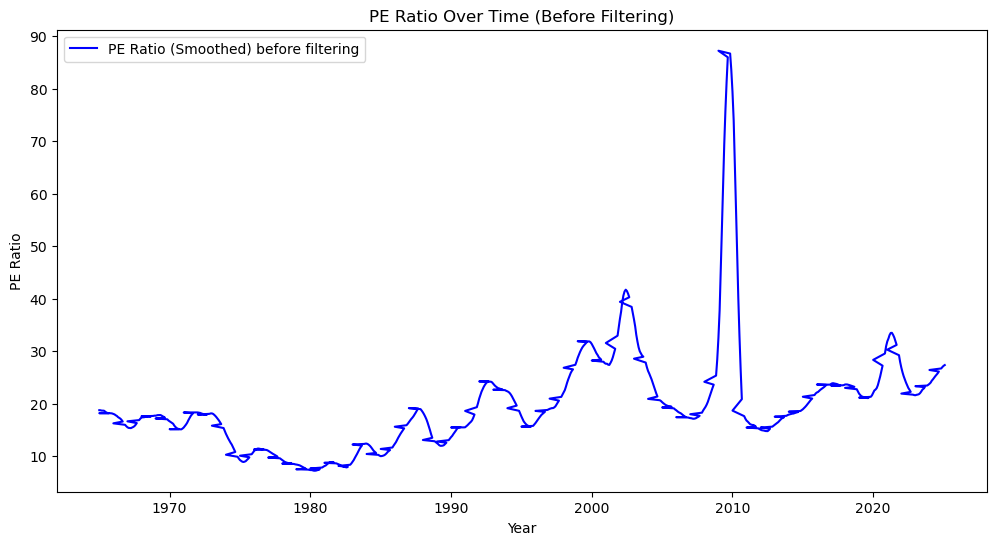

In [437]:
# Plot PE Ratio over time before filtering
plt.figure(figsize=(12,6))
plt.plot(df["Date"], df["PE Ratio"].rolling(window=12, min_periods=1).mean(), 
         label="PE Ratio (Smoothed) before filtering", color='blue')
plt.xlabel("Year")
plt.ylabel("PE Ratio")
plt.title("PE Ratio Over Time (Before Filtering)")
plt.legend()
plt.show()


In [438]:
# Compute the 5th and 95th percentiles
low_cutoff = df["PE Ratio"].quantile(0.05)
high_cutoff = df["PE Ratio"].quantile(0.95)

# Filter out outliers
df_filtered = df[(df["PE Ratio"] >= low_cutoff) & (df["PE Ratio"] <= high_cutoff)]


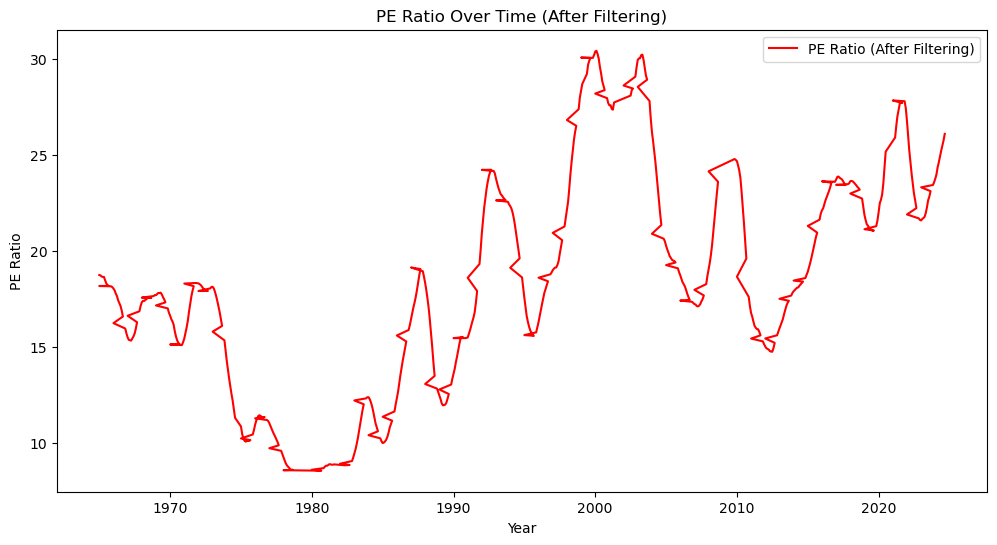

In [439]:
# Plot PE Ratio over time after filtering
plt.figure(figsize=(12,6))
plt.plot(df_filtered["Date"], df_filtered["PE Ratio"].rolling(window=12, min_periods=1).mean(), label="PE Ratio (After Filtering)", color='red')
plt.xlabel("Year")
plt.ylabel("PE Ratio")
plt.title("PE Ratio Over Time (After Filtering)")
plt.legend()
plt.show()


In [440]:
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test on PE Ratio
adf_pe = adfuller(df["PE Ratio"].dropna())  
print("ADF Statistic for PE Ratio:", adf_pe[0])
print("p-value for PE Ratio:", adf_pe[1])

# Perform the ADF test on 3-Year Return
adf_3y = adfuller(df["3 Year Annual Return"].dropna())
print("ADF Statistic for 3 Year Return:", adf_3y[0])
print("p-value for 3 Year Return:", adf_3y[1])

# Perform the ADF test on 5-Year Return
adf_5y = adfuller(df["5 Year Annual Return"].dropna())
print("ADF Statistic for 5 Year Return:", adf_5y[0])
print("p-value for 5 Year Return:", adf_5y[1])


ADF Statistic for PE Ratio: -3.71031496664492
p-value for PE Ratio: 0.003970382218308842
ADF Statistic for 3 Year Return: -3.175345070683767
p-value for 3 Year Return: 0.021456898272452687
ADF Statistic for 5 Year Return: -2.534919511794062
p-value for 5 Year Return: 0.10720751952146901


In [441]:
#IF P value is <0.05 we can reject the null hypothesis which means are data is stationary. 
#As a result, it looks like PE RATIO and 3 Year Annual Return Data is Stationary 
#However, it seems like 5 year annual return may not be stationary so will need to investigate if we need to fix and if so how

/var/folders/gd/8x_7tck95jx01q0_jm10xb1m0000gn/T/ipykernel_47604/70060429.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Date'] = pd.to_datetime(df['Date'])


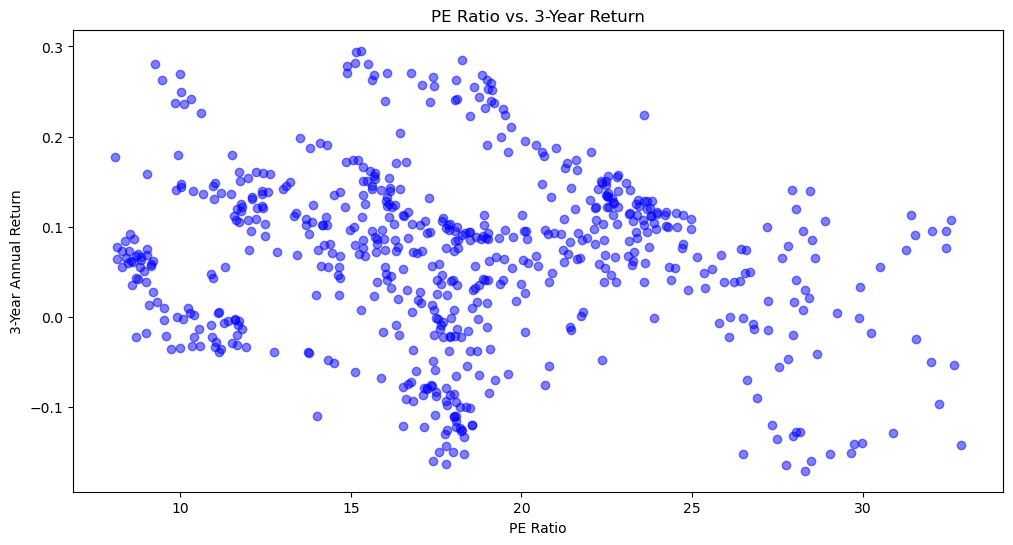

In [444]:
# Convert Date to datetime format
df_filtered['Date'] = pd.to_datetime(df['Date'])

# Set Date as the index for time series data
df_filtered.set_index('Date', inplace=True)

# Plot PE Ratio vs 3-Year Return to visually inspect the relationship
plt.figure(figsize=(12, 6))
plt.scatter(df_filtered['PE Ratio'], df_filtered['3 Year Annual Return'], color='blue', alpha=0.5)
plt.title("PE Ratio vs. 3-Year Return")
plt.xlabel("PE Ratio")
plt.ylabel("3-Year Annual Return")
plt.show()

plt.show()
